In [1]:
import sys
sys.path.append('../scripts/')
from kf import *

In [2]:
def make_ax():
    fig = plt.figure(figsize = (4,4))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_xlabel("X", fontsize = 10)
    ax.set_ylabel("Y", fontsize = 10)
    
    return ax


#軌跡の描画
def draw_trajectory(xs, ax): 
    poses = [xs[s] for s in range(len(xs))]
    ax.scatter([e[0] for e in poses], [e[1] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[0] for e in poses], [e[1] for e in poses], linewidth=0.5, color="black")

    
#センサ値の描画
def draw_observations(xs, zlist, ax):
    for s in range(len(xs)):
        if s not in zlist:
            continue
            
        for obs in zlist[s]:
            x, y, theta = xs[s]
            ell, phi = obs[1][0], obs[1][1]
            mx = x + ell*math.cos(theta + phi)
            my = y + ell*math.sin(theta + phi)
            ax.plot([x,mx], [y,my], color="pink", alpha=0.5)


    
def draw_edges(edges, ax):
    for e in edges:
        ax.plot([e.x1[0], e.x2[0]], [e.x1[1], e.x2[1]], color = "red", alpha = 0.5)
        
def draw_landmarks(ms, ax): ###graphbasedslam7draw
    ax.scatter([ms[k][0] for k in ms], [ms[k][1] for k in ms], s=100, marker="*", color="blue", zorder=100)
        
def draw(xs, zlist, edges, ms = []):
    ax = make_ax()
    draw_observations(xs, zlist, ax)
    #draw_edges(edges, ax)
    draw_trajectory(xs, ax)
    draw_landmarks(ms, ax)
    plt.show()

In [3]:
def read_data():
    hat_xs = {}
    zlist = {} 
    delta = 0.0
    us = {}

    with open("log2.txt") as f:
        for line in f.readlines():
            tmp = line.rstrip().split()

            step = int(tmp[1])
            if tmp[0] == "x": #姿勢のレコードの場合
                hat_xs[step] = np.array([float(tmp[2]), float(tmp[3]), float(tmp[4])]).T
            elif tmp[0] == "z": #センサ値のレコードの場合
                if step not in zlist:  #まだ辞書が空の時は空の辞書を作る
                    zlist[step] = []
                zlist[step].append((int(tmp[2]), np.array([float(tmp[3]), float(tmp[4])]).T)) # センサ値の２変数のみを保存
                
            elif tmp[0] == "delta":
                delta = float(tmp[1])
                
            elif tmp[0] == "u":
                us[step] = np.array([float(tmp[2]), float(tmp[3])]).T
                
        return hat_xs, zlist, us, delta

In [4]:
# 仮想移動エッジ
class ObsEdge:
    def __init__(self, t1, t2, z1, z2, xs, sensor_noise_rate = [0.14, 0.05]):
        assert z1[0] == z2[0] # ランドマークのidが異なれば止める
        
        self.t1, self.t2 = t1, t2
        self.x1, self.x2 = xs[t1], xs[t2]
        self.z1, self.z2 = z1[1], z2[1]
        
        s1 = math.sin(self.x1[2] + self.z1[1])
        c1 = math.cos(self.x1[2] + self.z1[1])
        s2 = math.sin(self.x2[2] + self.z2[1])
        c2 = math.cos(self.x2[2] + self.z2[1])
        
        hat_e = self.x2[0:2] - self.x1[0:2] + np.array([
            self.z2[0] * c2 - self.z1[0] * c1,
            self.z2[0] * s2 - self.z1[0] * s1
            ])

            
        # 精度行列の作成　３*３ Q_j,t1
        Q1 = np.diag([(self.z1[0] * sensor_noise_rate[0]) **2, sensor_noise_rate[1] **2])
        
        # 回転行列 R_j,t1
        R1 = -np.array([[c1, -self.z1[0] * s1],
                                    [ s1, self.z1[0] * c1]
                                   ])
        
        # 以下同様 Q_j,t2 R_j,t2
        Q2 = np.diag([(self.z2[0] * sensor_noise_rate[0]) **2, sensor_noise_rate[1] **2])
        R2 = -np.array([[c2, -self.z2[0] * s2],
                                    [ s2, self.z2[0] * c2]
                                   ])
        
        
        Sigma = R1.dot(Q1).dot(R1.T) + R2.dot(Q2).dot(R2.T) # Σ_j,t1,t2 
        Omega = np.linalg.inv(Sigma) # 精度行列完成 ψが消えたので2*2の行列になる
        
        #print(Sigma)
                
        # ヤコビ行列　B_j,t1
        B1 = - np.array([[1, 0, -self.z1[0]*s1],
                                    [0, 1, self.z1[0]*c1]])
        
        # ヤコビ行列　B_j,t2
        B2 = np.array([[1, 0,  -self.z2[0]*s2],
                                   [0, 1,   self.z2[0]*c2]])
        
        # 式(9.43)　の対応する部分の行列の各要素　左上、右上、左下、右下　の順
        self.omega_upperleft = B1.T.dot(Omega).dot(B1)
        self.omega_upperright = B1.T.dot(Omega).dot(B2)
        self.omega_bottomleft = B2.T.dot(Omega).dot(B1)
        self.omega_bottomright = B2.T.dot(Omega).dot(B2)
        
        # 式(9.44)の上半分と下半分の各要素
        
        self.xi_upper = - B1.T.dot(Omega).dot(hat_e)
        self.xi_bottom = - B2.T.dot(Omega).dot(hat_e)

In [5]:
import itertools
def make_edges(hat_xs, zlist):
    landmark_keys_zlist = {}
    
    for step in zlist:
        for z in zlist[step]:
            landmark_id = z[0]
            if landmark_id not in landmark_keys_zlist:
                landmark_keys_zlist[landmark_id] = []
                
            landmark_keys_zlist[landmark_id].append((step, z))
            
    edges = []
    for landmark_id in landmark_keys_zlist:
        step_pairs = list(itertools.combinations(landmark_keys_zlist[landmark_id], 2)) # センサの全部から二つ抽出したペア
        edges += [ObsEdge(xz1[0], xz2[0], xz1[1], xz2[1], hat_xs) for xz1, xz2 in step_pairs] # 同じランドマークを確認したペアをedgesに追加
        
    return edges, landmark_keys_zlist

In [6]:
def add_edge(edge, Omega, xi):
    # 行列の箱の準備 (3T+1) * (3T+1)
    f1, f2 = edge.t1 * 3, edge.t2 * 3
    t1, t2 = f1 + 3, f2 + 3
    
    # 行列の各要素を代入　Ω
    Omega[f1:t1, f1:t1] += edge.omega_upperleft
    Omega[f1:t1, f2:t2] += edge.omega_upperright
    Omega[f2:t2, f1:t1] += edge.omega_bottomleft
    Omega[f2:t2, f2:t2] += edge.omega_bottomright
    
    # ζ
    xi[f1:t1] += edge.xi_upper
    xi[f2:t2] += edge.xi_bottom

In [7]:
class MotionEdge:
    def __init__(self, t1, t2, xs, us, delta, motion_noise_stds = {"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        self.t1, self.t2 = t1, t2
        self.hat_x1, self.hat_x2 = xs[t1], xs[t2]
        
        nu, omega = us[t2]
        if abs(omega) < 1e-5: omega = 1e-5
            
        M = matM(nu, omega, delta, motion_noise_stds)
        A = matA(nu, omega, delta, self.hat_x1[2])
        F = matF(nu, omega, delta, self.hat_x1[2])
        
        self.Omega = np.linalg.inv(A.dot(M).dot(A.T) + np.eye(3)*0.0001) #標準偏差0.01の雑音を足す
        
        self.omega_upperleft = F.T.dot(self.Omega).dot(F)
        self.omega_upperright = -F.T.dot(self.Omega)
        self.omega_bottomleft = - self.Omega.dot(F)
        self.omega_bottomright = self.Omega
        
        x2 = IdealRobot.state_transition(nu, omega, delta, self.hat_x1)
        self.xi_upper = F.T.dot(self.Omega).dot(self.hat_x2 - x2)
        self.xi_bottom = -self.Omega.dot(self.hat_x2 - x2)

1回目の繰り返し: 4.1419218692027275
2回目の繰り返し: 1.199288962729069
3回目の繰り返し: 0.48016084320720437
4回目の繰り返し: 0.2147678011112217
5回目の繰り返し: 0.09613702349286776
6回目の繰り返し: 0.04274232461205136
7回目の繰り返し: 0.01869727607379661
8回目の繰り返し: 0.007872828723164903


<IPython.core.display.Javascript object>


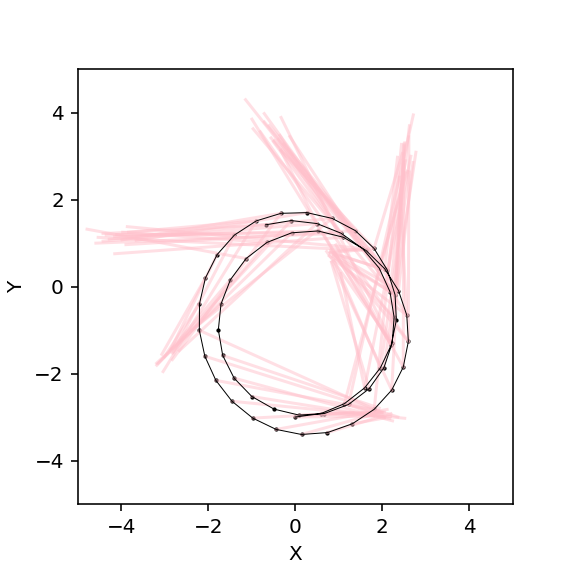

In [8]:
hat_xs, zlist, us, delta = read_data() 
dim = len(hat_xs)*3  #軌跡をつなげたベクトルの次元

for n in range(1, 10000):  #繰り返しの回数は適当に大きな値にしておく（終了判定は別途下で）
    ##エッジ、大きな精度行列、係数ベクトルの作成##

    edges, _ = make_edges(hat_xs, zlist) 
    
    for i in range(len(hat_xs)-1):
        for j in range(100): # λ = 100
            edges.append(MotionEdge(i, i+1, hat_xs, us, delta))
            
        
    Omega = np.zeros((dim, dim))
    xi = np.zeros(dim)
    Omega[0:3, 0:3] += np.eye(3)*1000000  #x0の固定
    
        
    ##軌跡を動かす量（差分）の計算##
    for e in edges:
        add_edge(e, Omega, xi) #エッジの精度行列、係数ベクトルをOmega, xiに足す

    delta_xs = np.linalg.inv(Omega).dot(xi) #求めた差分 足すべき差分
    
    ##推定値の更新##
    for i in range(len(hat_xs)):
        hat_xs[i] += delta_xs[i*3:(i+1)*3]    #差分を足して新たな推定値を作る
        
    ##終了判定###
    diff = np.linalg.norm(delta_xs)           #差分の大きさ（L2ノルム）を求める
    print("{}回目の繰り返し: {}".format(n, diff))
    if diff < 0.01:                                        #閾値は調整する必要があるかもしれません
        draw(hat_xs, zlist, edges) #収束したら描画。drawでdraw_edgesを呼び出している行はコメントアウトしておく
        break
        
# ロボットの軌跡っぽく軌跡を推定できてるかな

In [9]:
_, zlist_landmark = make_edges(hat_xs, zlist)
zlist_landmark
# landmarkごとのlandmarkを観測した時刻とそのセンサ値
# (秒 ,landmark, [l, φ, ψ])

{1: [(0, (1, array([1.79959093, 0.00872824]))),
  (1, (1, array([ 1.4139218 , -0.23914524]))),
  (2, (1, array([ 0.97538914, -0.86355777]))),
  (19, (1, array([4.60236879, 1.04615677]))),
  (20, (1, array([4.65151741, 0.94884481]))),
  (21, (1, array([3.78722947, 0.84788779]))),
  (22, (1, array([3.99085913, 0.69702475]))),
  (23, (1, array([2.31092426, 0.62478651]))),
  (24, (1, array([2.59325786, 0.50820041]))),
  (25, (1, array([1.86508548, 0.33649116]))),
  (26, (1, array([1.52287312, 0.07923329]))),
  (27, (1, array([ 0.73852011, -0.28969573]))),
  (44, (1, array([3.79727419, 0.93818501]))),
  (45, (1, array([3.77303154, 0.68670527]))),
  (46, (1, array([3.21235506, 0.49793817]))),
  (48, (1, array([1.96401749, 0.126591  ]))),
  (49, (1, array([ 1.52321709, -0.25547043]))),
  (50, (1, array([ 0.82241478, -0.79460474])))],
 2: [(2, (2, array([5.48996388, 0.7752287 ]))),
  (3, (2, array([5.43054394, 0.5833879 ]))),
  (4, (2, array([4.55197333, 0.40701664]))),
  (5, (2, array([4.6311

In [10]:
class MapEdge:
    def __init__(self, t, z, head_t, head_z, xs, sensor_noise_rate = [0.14, 0.05]):
        self.x = xs[t]
        self.z = z
        
        self.m = self.x[0:2] + np.array([z[0] * math.cos(self.x[2] + z[1]), z[0] * math.sin(self.x[2] + z[1])]).T
        
        #while self.m[2] >= math.pi: self.m[2] -= math.pi * 2
        #while self.m[2] < -math.pi: self.m[2] += math.pi * 2
            
        Q1 = np.diag([(self.z[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2])
        
        s1 = math.sin(self.x[2] + self.z[1]) 
        c1 = math.cos(self.x[2] + self.z[1])
        R = np.array([[-c1, self.z[0]*s1],
                                [-s1,-self.z[0]*c1]
                               ])
        
        self.Omega = np.linalg.inv(R.dot(Q1).dot(R.T)) # 2*2の行列
        self.xi = self.Omega.dot(self.m) # 二次元ベクトル
        

<IPython.core.display.Javascript object>


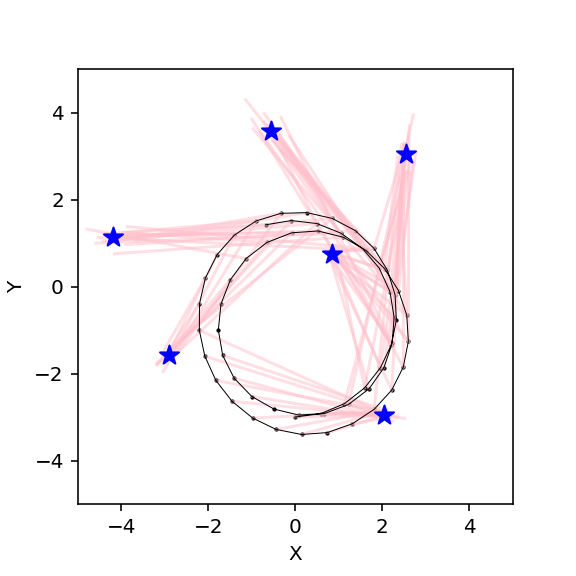

In [11]:
ms = {}
for landmark_id in zlist_landmark:
    edges = []
    head_z = zlist_landmark[landmark_id][0] # 最初の観測
    for z in zlist_landmark[landmark_id]:
        edges.append(MapEdge(z[0], z[1][1], head_z[0], head_z[1][1], hat_xs))
        
    #ms[landmark_id] = np.mean([e.m for e in edges], axis = 0) # ランドマークの位置が推定できている（誤差があるが）
    Omega = np.zeros((2,2))
    xi = np.zeros(2)
    for e in edges:
        Omega += e.Omega
        xi += e.xi
        
        
    #ms[landmark_id] = np.linalg.inv(Omega).dot(xi)
    ms[landmark_id] = np.mean([e.m for e in edges], axis=0)
    #ms.append(np.linalg.inv(Omega).dot(xi))
    
draw(hat_xs, zlist, edges, ms) # バイアスの誤差を小さくすればもっと精度は上がる

In [12]:
ms

{1: array([ 2.04748423, -2.94215404]),
 2: array([2.55375739, 3.05869346]),
 4: array([0.84859275, 0.74571119]),
 3: array([-0.56311014,  3.56730773]),
 0: array([-4.18478437,  1.12909006]),
 5: array([-2.91184602, -1.58082567])}